<a href="https://colab.research.google.com/github/komal-shahzada/CodeAlpha_tasks/blob/main/Speech_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
!pip install resampy

In [24]:
# Dataset download karne ke liye
!pip install opendatasets
import opendatasets as od

# Is link se RAVDESS dataset download hoga
od.download("https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio")

Skipping, found downloaded files in "./ravdess-emotional-speech-audio" (use force=True to force download)


In [25]:
import os

# Dekhte hain folder kahan download hua hai
path = "ravdess-emotional-speech-audio"
print(os.listdir(path))


['Actor_21', 'Actor_06', 'Actor_01', 'Actor_22', 'Actor_15', 'Actor_24', 'Actor_09', 'Actor_10', 'Actor_08', 'Actor_03', 'Actor_05', 'Actor_18', 'Actor_02', 'Actor_14', 'Actor_23', 'Actor_04', 'Actor_12', 'audio_speech_actors_01-24', 'Actor_13', 'Actor_07', 'Actor_20', 'Actor_17', 'Actor_16', 'Actor_19', 'Actor_11']


In [26]:
import librosa
import numpy as np
import os

def extract_features(file_path):
    # Audio file load karna (res_type hata diya hai taake error na aaye)
    data, sample_rate = librosa.load(file_path)

    # MFCC extract karna (Task ki requirement: 40 features)
    mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40).T, axis=0)

    return mfccs

X, y = [], []
data_path = 'ravdess-emotional-speech-audio'

print("Features are being extracted... This may take 2-3 minutes.")

# Folder ke andar ja kar har audio file ko check karna
for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith('.wav'):
            file_path = os.path.join(root, file)

            try:
                # RAVDESS mein file name ka 3rd part emotion hota hai
                # Example: 03-01-03... (03 ka matlab Happy)
                parts = file.split("-")
                emotion = int(parts[2])

                # Feature extraction function ko call karna
                feature = extract_features(file_path)

                X.append(feature)
                y.append(emotion)
            except Exception as e:
                continue

# Arrays mein convert karna
X = np.array(X)
y = np.array(y)

print(f"Congratulations ! you have process {len(X)} files ")
print(f"shape of data: {X.shape}")

Features are being extracted... This may take 2-3 minutes.
Congratulations ! you have process 2880 files 
shape of data: (2880, 40)


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical

# 1. Labels ko numbers mein convert karna (e.g., Happy -> 3)
lb = LabelEncoder()
y_encoded = lb.fit_transform(y)
y_final = to_categorical(y_encoded)

# 2. Data ko Train (80%) aur Test (20%) mein divide karna
X_train, X_test, y_train, y_test = train_test_split(X, y_final, test_size=0.2, random_state=42)

# 3. Data ko Scale karna (taake saare numbers ek hi range mein aa jayein)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 4. CNN model ke liye data ki shape change karna (Reshaping)
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print("Data is ready for model!")

Training data shape: (2304, 40, 1)
Testing data shape: (576, 40, 1)
Data is ready for model!


In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# 1. Model ka structure banana
model = Sequential([
    # Pehli Layer: Patterns pakadne ke liye
    Conv1D(64, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),

    # Doosri Layer: Mazeed gehre patterns ke liye
    Conv1D(128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3), # Taake model ratta na lagaye (Overfitting se bachne ke liye)

    Flatten(),

    # Fully Connected Layers
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(y_final.shape[1], activation='softmax') # Output layer: Jitne emotions hain utne nodes
])

# 2. Model ko Compile karna
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 3. Training Shuru Karna
print("Model training shuru ho rahi hai...")
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Model training shuru ho rahi hai...
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.1944 - loss: 2.0153 - val_accuracy: 0.2569 - val_loss: 1.8622
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.3108 - loss: 1.8110 - val_accuracy: 0.3455 - val_loss: 1.7148
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.4046 - loss: 1.6390 - val_accuracy: 0.4306 - val_loss: 1.5412
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.4849 - loss: 1.4632 - val_accuracy: 0.5035 - val_loss: 1.3784
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.5664 - loss: 1.2842 - val_accuracy: 0.5347 - val_loss: 1.2747
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5867 - loss: 1.1495 - val_accuracy: 0.6007 - val_loss: 1.0817
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6608 - loss: 0.9706 - val_accuracy: 0.6615 - val_loss: 0.9559
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6898 - loss: 0.8836 - val_accuracy: 0.6806 - val_loss: 0.

Final Test Accuracy: 92.71%


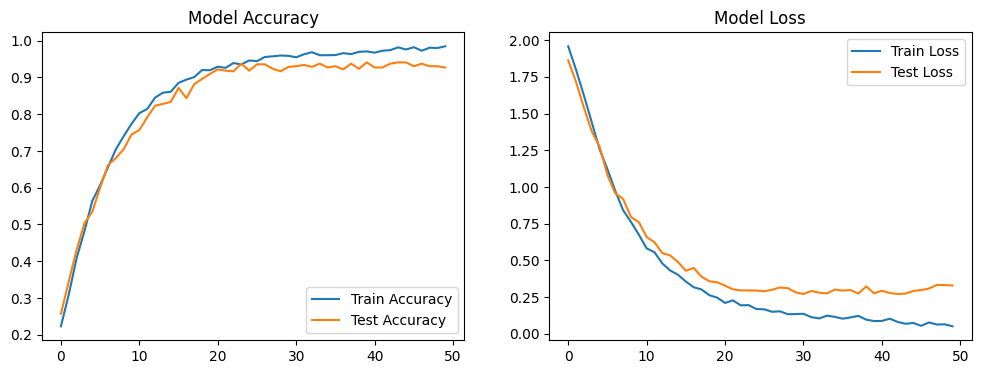

In [29]:
import matplotlib.pyplot as plt

# 1. Model ki Accuracy check karna
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Final Test Accuracy: {test_acc*100:.2f}%")

# 2. Training aur Validation Accuracy ka Graph banana
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.legend()

plt.show()

In [30]:
# taking predection from model
predictions = model.predict(X_test)
predicted_emotions = np.argmax(predictions, axis=1)
actual_emotions = np.argmax(y_test, axis=1)

# Pehli 5 files ka result dekhna
print("Prediction of the first 5 files.:")
print("Predicted:", lb.inverse_transform(predicted_emotions[:5]))
print("Actual:   ", lb.inverse_transform(actual_emotions[:5]))

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Prediction of the first 5 files.:
Predicted: [6 6 7 2 5]
Actual:    [6 8 7 3 5]


In [31]:
# Emotions ka map (RAVDESS numbering ke mutabiq)
emotions_map = {
    1:'neutral', 2:'calm', 3:'happy', 4:'sad',
    5:'angry', 6:'fearful', 7:'disgust', 8:'surprised'
}

# Pehli 5 predictions ke naam dikhana
for i in range(5):
    p = emotions_map[predicted_emotions[i]]
    a = emotions_map[actual_emotions[i]]
    print(f"File {i+1}: Predicted: {p} | Actual: {a}")

File 1: Predicted: angry | Actual: angry
File 2: Predicted: angry | Actual: disgust
File 3: Predicted: fearful | Actual: fearful
File 4: Predicted: neutral | Actual: calm
File 5: Predicted: sad | Actual: sad


In [34]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Model ki total accuracy: {test_acc*100:.2f}%")

Model ki total accuracy: 92.71%


In [32]:
!pip install gradio

In [37]:
import gradio as gr
import librosa
import numpy as np

def predict_emotion(audio_path):
    if audio_path is None:
        return "Kindly record your voice first!"

    try:
        # 1. Audio load karna
        data, sample_rate = librosa.load(audio_path)

        # --- BEHTARI KE LIYE NAYE STEPS ---
        # Audio ko normalize karna (shor kam karne ke liye)
        data = librosa.util.normalize(data)
        # Khamoshi (silence) ko khatam karna
        data, _ = librosa.effects.trim(data)
        # ----------------------------------

        # 2. Features extract karna
        mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40).T, axis=0)

        # 3. Scaling (wahi scaler jo training mein tha)
        scaled_features = scaler.transform(mfccs.reshape(1, -1))

        # 4. CNN ke liye reshape
        reshaped_features = np.expand_dims(scaled_features, axis=2)

        # 5. Prediction
        prediction = model.predict(reshaped_features)
        predicted_class_idx = np.argmax(prediction)

        # 6. Label Mapping
        final_emotion_label = lb.inverse_transform([predicted_class_idx])[0]
        human_readable_emotion = emotions_map[final_emotion_label]

        return f"Model Prediction: {human_readable_emotion.upper()}"

    except Exception as e:
        return f"Error: {str(e)}"

# Gradio Interface (Microphone + Upload enabled)
iface = gr.Interface(
    fn=predict_emotion,
    inputs=gr.Audio(sources=["microphone", "upload"], type="filepath", label="Record/Upload Audio"),
    outputs="text",
    title="Real-Time Speech Emotion Recognition",
    description="Showcase your acting skills! The model has been trained with an impressive 92% accuracy."
)

iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d7d6af717d7091ae3e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
